In [1]:
import scanpy as sc

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns

from scipy.stats import fisher_exact

import numpy as np

import pandas as pd

import plotting_utils as pl

sc.set_figure_params(dpi=120)
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
response_palette = {'R':'teal','NR':[1,.2,0]}

subtype_colors = {'CD4 T':'blue','CD8 T':'orange'}
class_colors = {'T-reg':'green','EM':'tab:olive','SLEC':'grey','CM':'tab:purple','CTL':'teal'}

class_colors_cont = dict()
for cl in class_colors.keys(): 
    class_colors_cont[cl] = LinearSegmentedColormap.from_list(cl + ' cmap',['white',class_colors[cl]])


In [3]:
import pickle
with open("../data/CART_subclustering_Ionly.3.pkl","rb") as f:
    adatas = pickle.load(f)

In [4]:
for product in ['Kymriah','Yescarta']:
    for subtype in ['CD8 T','CD4 T']:
        for timepoint in ['Infusion','D7-CAR-T']:
            adata=adatas[product][subtype][timepoint]
            
            adata.obs['class'] = adata.obs['name'].str.replace(' .*','')
            for c,g in adata.obs.groupby('class'):
    
                adata_sub = adata[g.index]
        
                name_sort = adata_sub.obs['name'].value_counts().reset_index().reset_index().set_index('index')
                adata_sub.obs['cluster_num'] = adata_sub.obs['name'].map(name_sort['level_0']).astype(int)+1
        
                adata.obs.loc[g.index,'numbered_name'] = c + ' ' + adata_sub.obs['cluster_num'].astype(str) if adata_sub.obs['cluster_num'].nunique()>1 \
                                                    else c 
                adata.obs.loc[g.index,'cluster_num'] = adata_sub.obs['cluster_num']
            

<ipython-input-4-776fbe7cd3cc>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  adata.obs['class'] = adata.obs['name'].str.replace(' .*','')
<ipython-input-4-776fbe7cd3cc>:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_sub.obs['cluster_num'] = adata_sub.obs['name'].map(name_sort['level_0']).astype(int)+1


## Figure 4a

<ipython-input-9-53163e834484>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  adata.obs['class'] = adata.obs['name'].str.replace(' .*','')
/home/njharlen/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


['CM' 'EM']
['SLEC' 'EM']
['CTL' 'CM' 'EM']
['CTL' 'EM']
['CM' 'EM']
['EM' 'CM']
['CTL' 'EM' 'CM' 'T-reg']
['CTL' 'CM' 'T-reg']


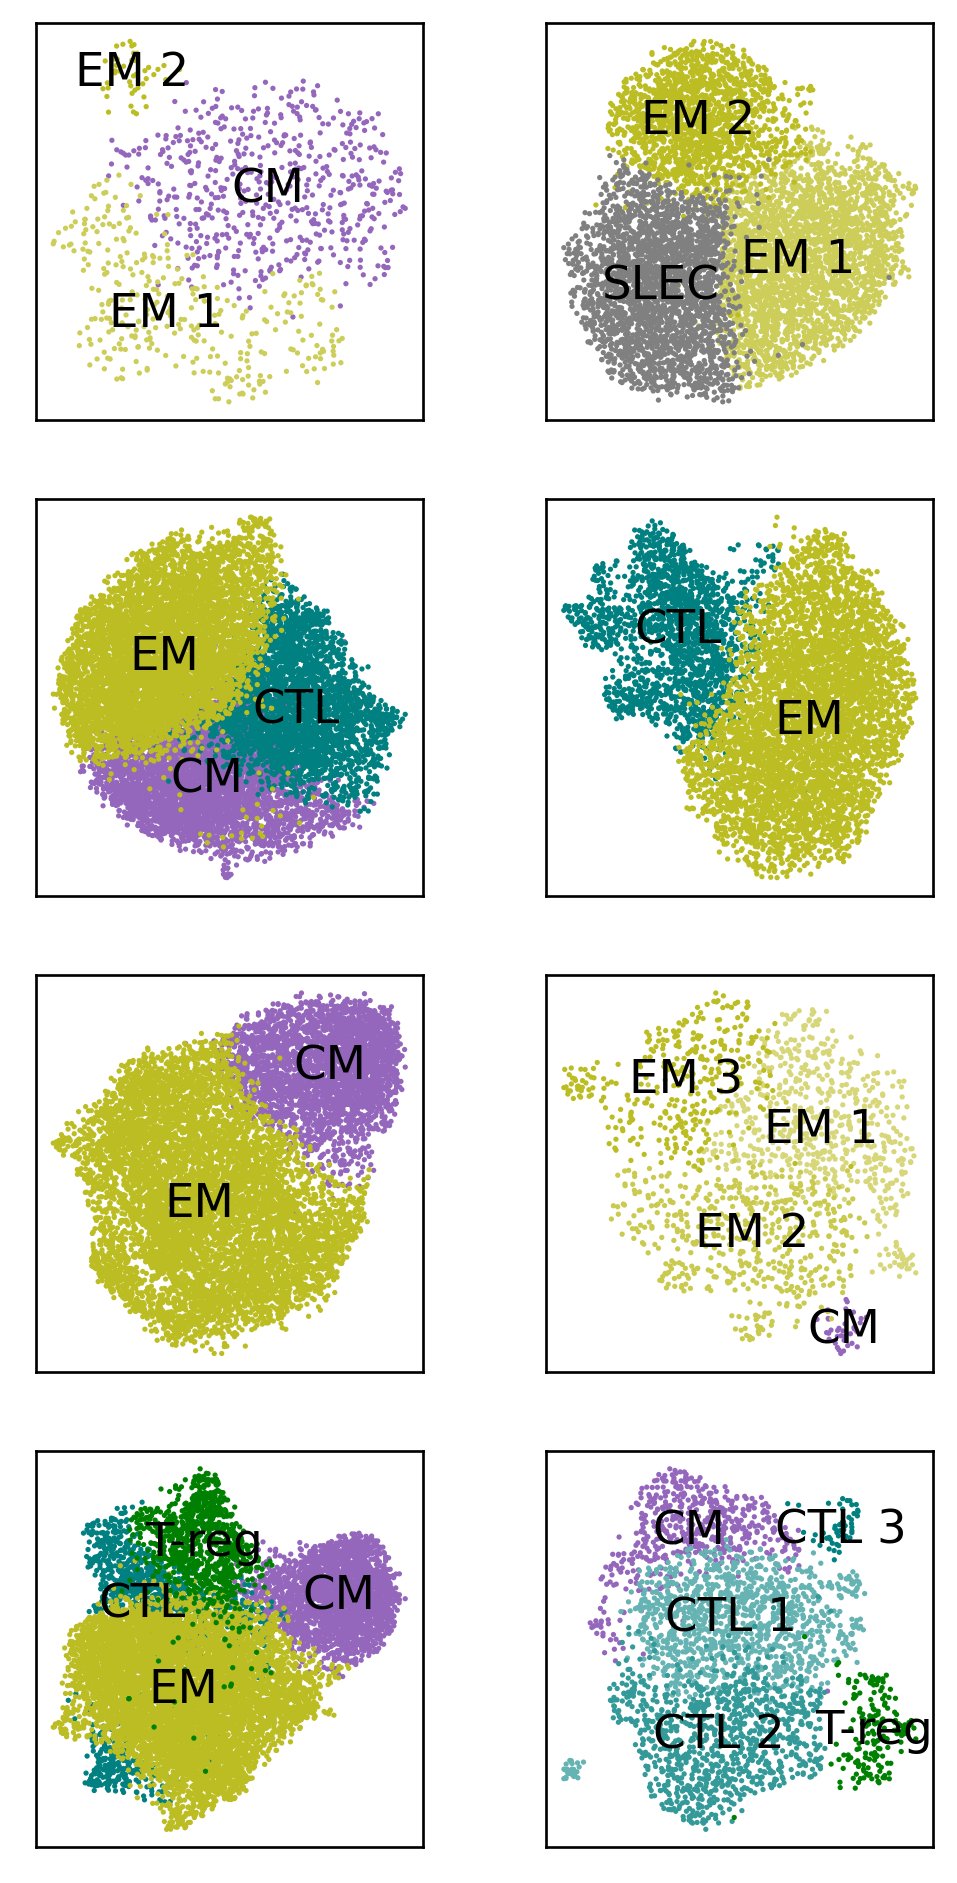

In [9]:
#class_colors = {'T-reg':'Reds','EM':'Oranges','SLEC':'Greys','CM':'Purples','CTL':'Greens'}


f,ax = plt.subplots(4,2,figsize=(5,10))
ax=ax.reshape(-1)
i=0
for product in ['Kymriah','Yescarta']:
    for subtype in ['CD8 T','CD4 T']:
        for timepoint in ['Infusion','D7-CAR-T']:
            adata=adatas[product][subtype][timepoint]
            
            adata.obs['class'] = adata.obs['name'].str.replace(' .*','')
            print(adata.obs['class'].unique())


            for c,g in adata.obs.groupby('class'):
    
                adata_sub = adata[g.index]
    
                cmax = adata_sub.obs['cluster_num'].max()
    
                gplot = sc.pl.umap(adata_sub,color='cluster_num',
                   show=False,size=10,legend_loc = 'on data',ax=ax[i],
                                   color_map=class_colors_cont[c],vmin=-2,vmax=cmax)
                #gplot.collections[0].colorbar.remove()
                gplot.collections[-1].colorbar.remove()
                
                # Label clusters
                for clust,gsub in adata_sub.obs.groupby('numbered_name'):
                    loc = np.median(adata[gsub.index].obsm['X_umap'],axis=0)
                    ax[i].text(loc[0],loc[1],clust,ha='center',va='center')
            
            ax[i].set_title('')
            ax[i].set_xlabel('')
            ax[i].set_ylabel('')

            #f.colorbar(cax=ax[i]).remove()
            
            i+=1

### Figure 4b

In [5]:
# Compile cell numbers

Xs = list()
for product in ['Kymriah','Yescarta']:
    for subtype in ['CD8 T','CD4 T']:
        for timepoint in ['Infusion','D7-CAR-T']:
            adata = adatas[product][subtype][timepoint]
            response_map =  adata.obs[['barcode','response']].drop_duplicates().set_index('barcode')['response']
            
            X=pd.crosstab(adata.obs['numbered_name'],adata.obs['barcode'])
            X.columns=X.columns.astype(str)
            X=X.reset_index().melt(id_vars='numbered_name',value_name='n')
            X['product']=product
            X['subtype']=subtype
            X['timepoint']=timepoint
            X['class'] = X['numbered_name'].str.replace(' .*','')
            X['response'] = X['barcode'].map(response_map)

            Xs.append(X)
X = pd.concat(Xs,axis=0).reset_index(drop=True)
X['timepoint']=pd.Categorical(X['timepoint'],categories=['Infusion','D7-CAR-T'])

<ipython-input-5-66a26dabae14>:16: FutureWarning: The default value of regex will change from True to False in a future version.
  X['class'] = X['numbered_name'].str.replace(' .*','')


In [6]:
X = X.rename(columns={'numbered_name':'name'})

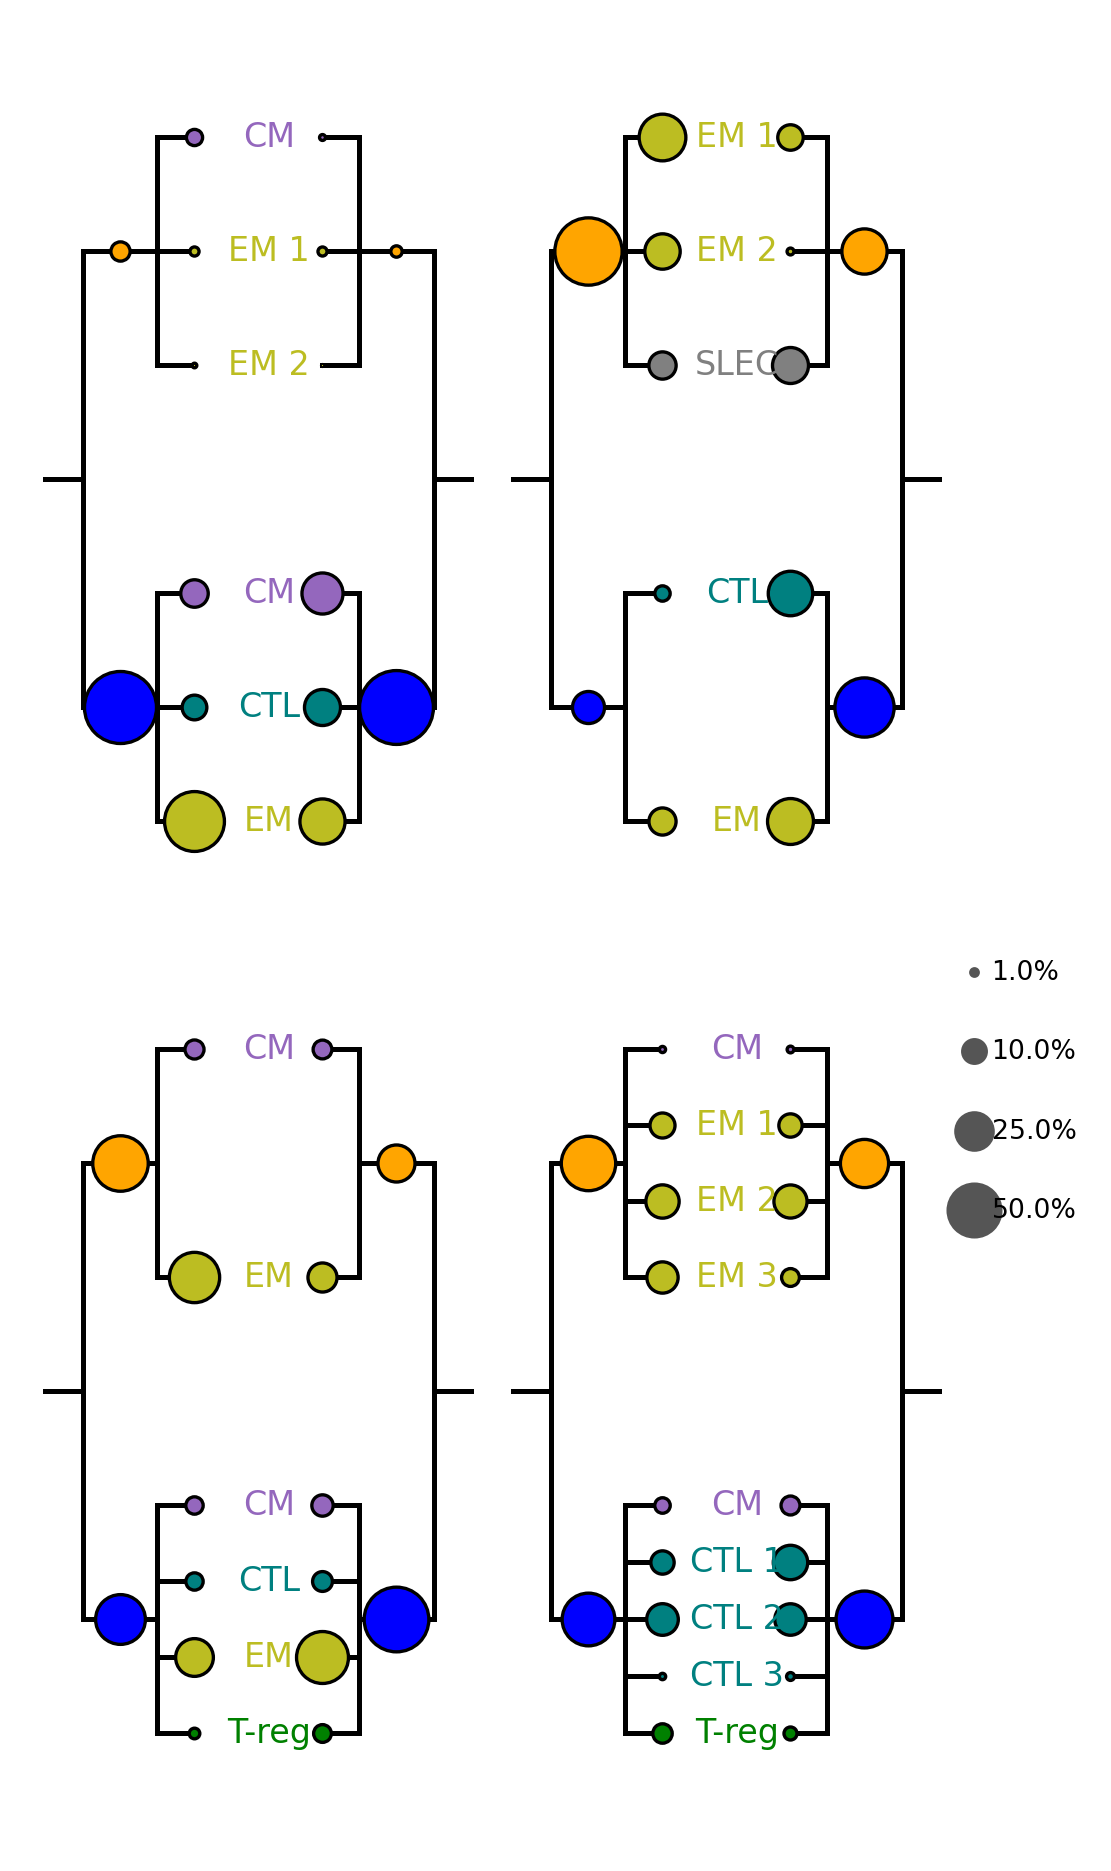

In [7]:
f,ax = plt.subplots(2,2,figsize=(5,10))
ax = ax.reshape(-1)


xspan=.35
yspan=1
size_scale=500

i=0

for ind,g in X.groupby(['product','timepoint']):

    idx1 = g['response']=='R'
    
    pl.pat_breakdown_plot(g[idx1],ax=ax[i],
                           root = (-1,0),xspan=xspan,yspan=yspan,size_scale=size_scale,label=True,fontsize=10)
    idx2=g['response']=='NR'
    pl.pat_breakdown_plot(g[idx2],
                           direction=-1,ax=ax[i],root = (1,0),
                           xspan=xspan,yspan=yspan,size_scale=size_scale)
    ax[i].set_ylim(-1,1)
    ax[i].axis('off')

    i+=1
    
plt.subplots_adjust(wspace=0, hspace=0)


pl.make_circle_legend([.01,.1,.25,.5],size_scale,ax[-1],labelspacing=2,bbox_to_anchor=(1.3,1))

### Figure 4c

/home/njharlen/anaconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


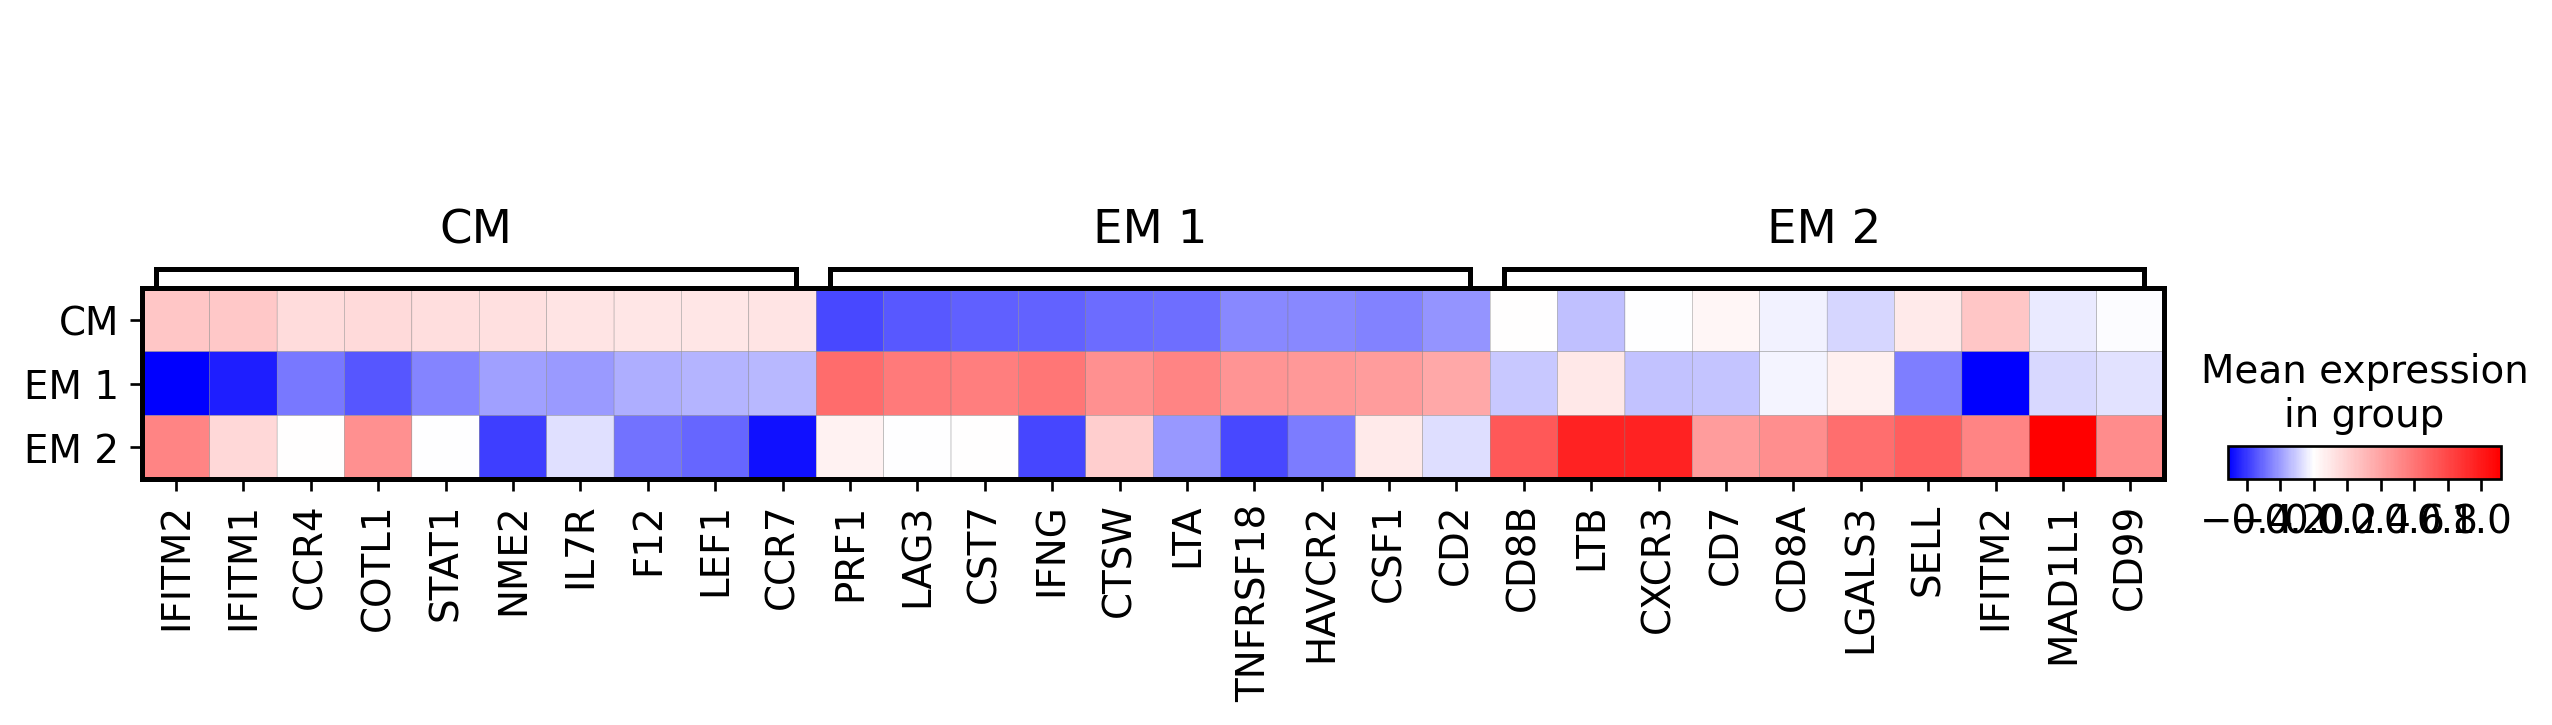

In [10]:
adata = adatas['Kymriah']['CD8 T']['Infusion']
sc.tl.rank_genes_groups(adata,'numbered_name',use_raw=False)
g=sc.pl.rank_genes_groups_matrixplot(adata,
            show=False,var_group_rotation=0,dendrogram=False,
                                     use_raw=False,cmap='bwr',vcenter=0)

### Figure 4d

In [27]:
X = pd.crosstab([adata.obs['barcode'],adata.obs['response']],adata.obs['numbered_name'])
idx = X.sum(axis=1)>=25
X=X[idx]
F = (X.T/X.T.sum()).T.reset_index().set_index('barcode')
F['response'] = pd.Categorical(F['response'],categories=['R','NR'])

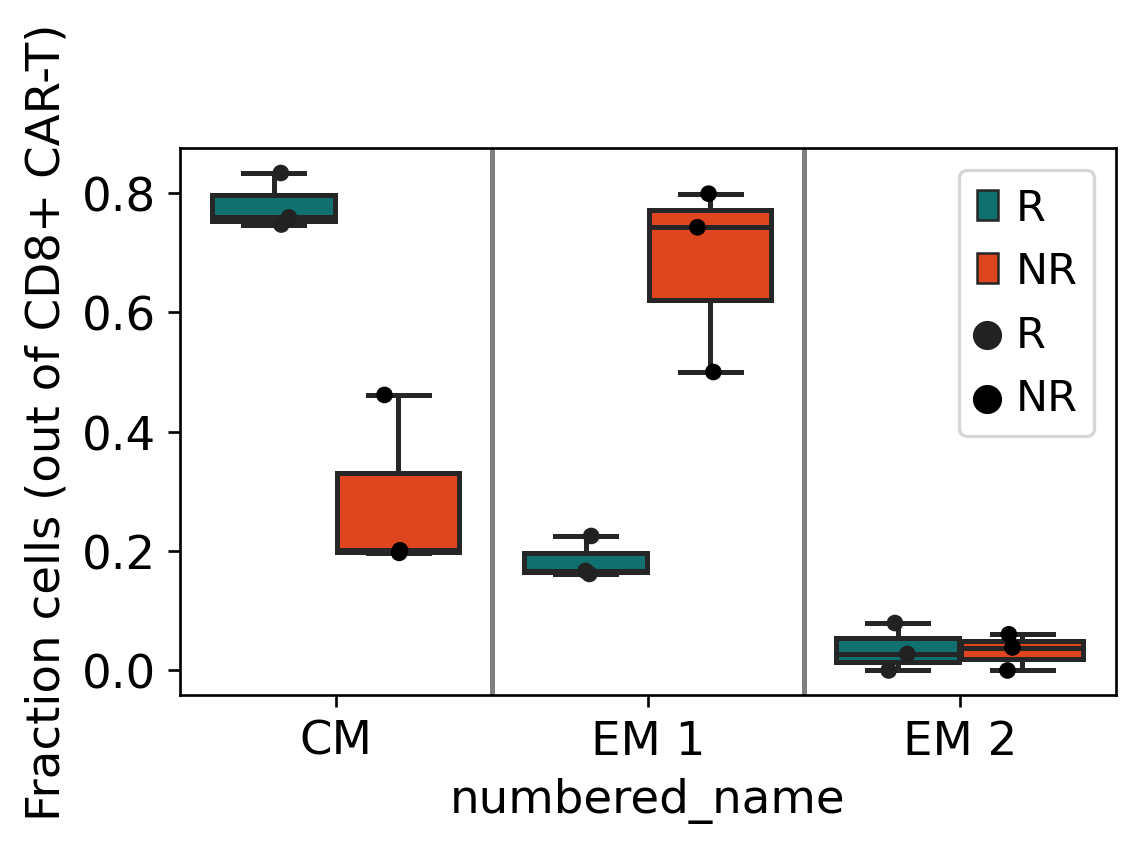

In [29]:

plt.figure(figsize=(5,3))
sns.boxplot(x="numbered_name",hue="response",y="value",data=F.melt(id_vars='response'),
            palette=response_palette)
sns.stripplot(x="numbered_name",hue="response",y="value",data=F.melt(id_vars='response'),
            color='k',dodge=True)


plt.grid(False)
plt.axvline(.5,color='gray')
plt.axvline(1.5,color='gray')
plt.ylabel('Fraction cells (out of CD8+ CAR-T)')
plt.legend(bbox_to_anchor=(1,1))

### Figure 4e

/home/njharlen/anaconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


{'mainplot_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5c95c99a60>,
 'gene_group_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5c95ca0730>,
 'color_legend_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5cbd17fbe0>}

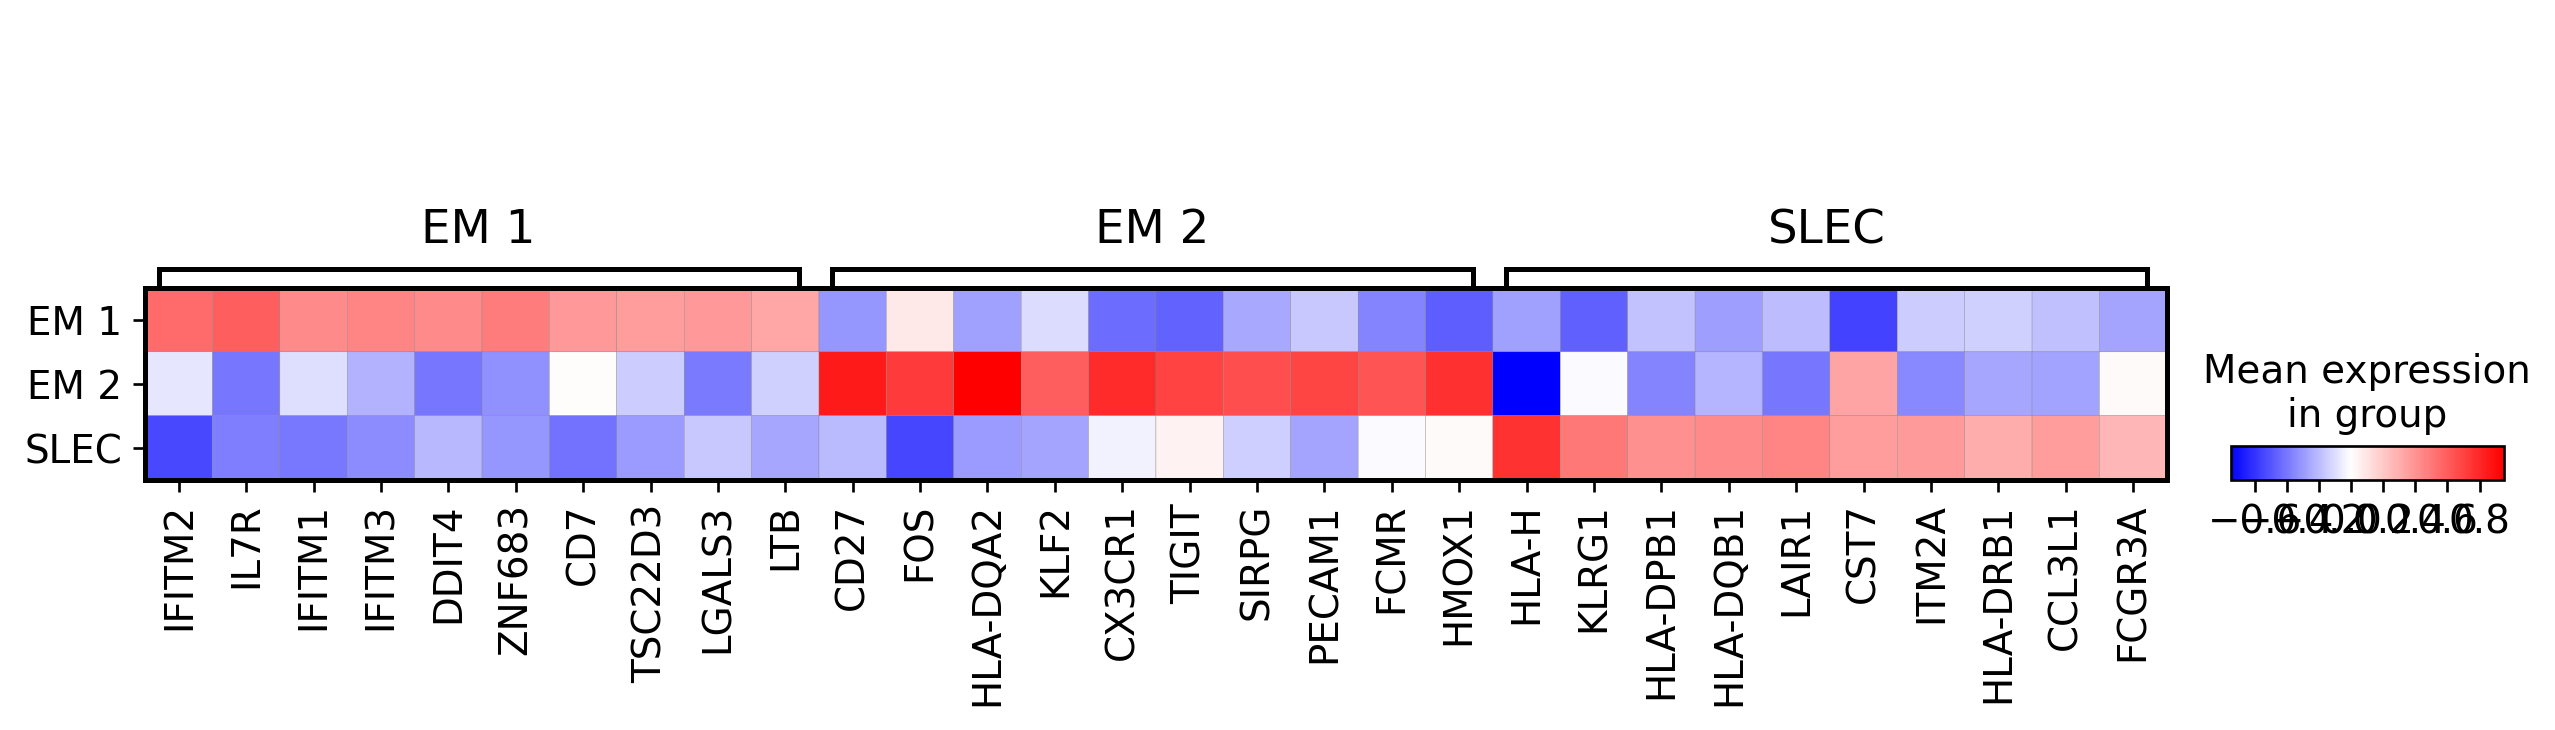

In [30]:
adata = adatas['Kymriah']['CD8 T']['D7-CAR-T']
sc.tl.rank_genes_groups(adata,'numbered_name',use_raw=False)
sc.pl.rank_genes_groups_matrixplot(adata,
            show=False,var_group_rotation=0,dendrogram=False,use_raw=False,cmap='bwr',vcenter=0)

### Figure 4g

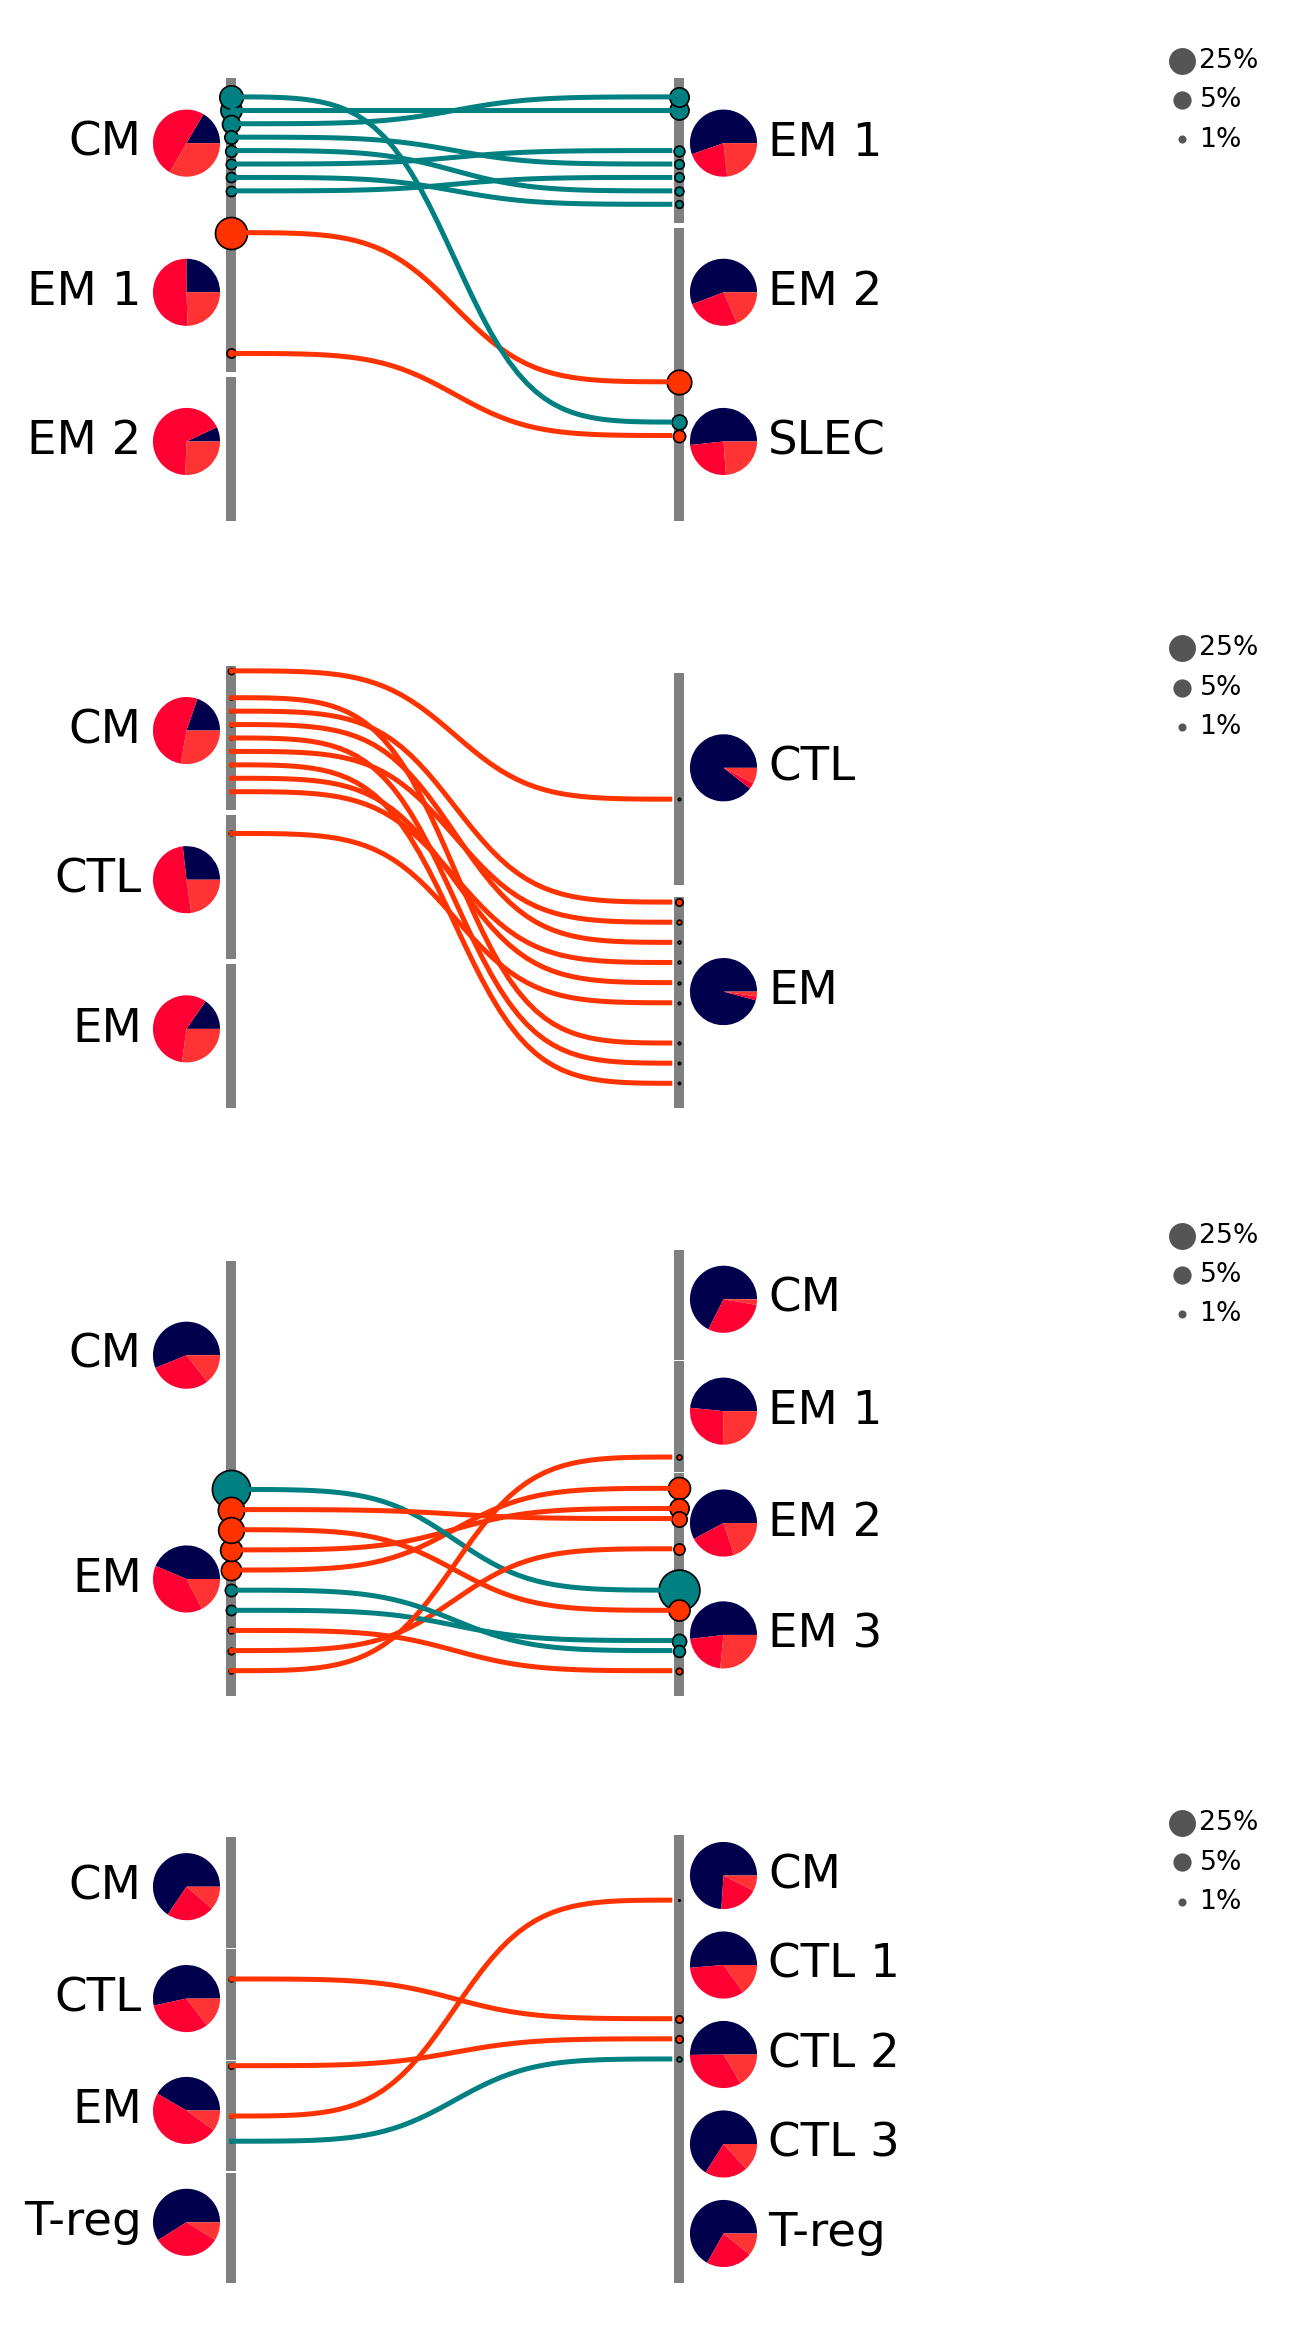

In [8]:
f,ax = plt.subplots(4,1,figsize=(15,10))

i=0
for product in ['Kymriah','Yescarta']:
    for subtype in ['CD8 T','CD4 T']:
        pl.clone_tracking_plot(adatas,product,subtype,ax=ax[i],sscale=200,key='numbered_name')
        i+=1
plt.tight_layout()